In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

В этом ноутбуке предлагается обучить модель классификации изображений датасета CIFAR10, который содержит 60к цветных картинок разрешения 32х32 принадлежащих 10 классам.

Загрузим датасет

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Отрисуем несколько картинок, посмотрим, как выглядит наш датасет



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


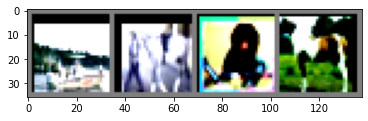

 ship horse   dog horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Сделаем простую модель на сверточных слоях с несколькими полносвязными слоями в конце.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.Tanh()(self.conv1(x)))
        x = self.pool(nn.Tanh()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        x = nn.Softmax()(self.fc3(x))
        return x


net = Net()

Закинем модель на ГПУ. Выберем в качестве лосс-функции кросс-энтропию. В качестве оптимизатора возьмем Адам.

In [ ]:
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Обучим модель

In [ ]:
for epoch in range(2):  

    for X_batch, y_batch in tqdm(trainloader):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()

        predictions = net(X_batch)

        loss = criterion(predictions, y_batch)
        loss.backward()

        optimizer.step()


100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


Посчитаем точность предсказания на валидационной выборке.

In [ ]:
for X_batch, y_batch in testloader:
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    with torch.no_grad():
        predictions = net(X_batch)

    true_lab = y_batch.cpu().numpy()
    _, preds = torch.max(predictions, dim=1)
    # print(true_lab)
    # print(preds)
    print('accuracy_score: ', accuracy_score(true_lab, preds.detach().cpu().numpy()))


accuracy_score:  0.4126
